In [2]:
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp
import jax.scipy as jsp

rate = np.ones(10000) * 20.0
sampling_frequency = 1000
spikes = np.random.poisson(rate / sampling_frequency)

design_matrix = np.ones((spikes.shape[0], 1))


@jax.jit
def neglogp(coefficients, spikes=spikes, design_matrix=design_matrix):
    conditional_intensity = jnp.exp(design_matrix @ coefficients)
    log_likelihood = jax.scipy.stats.poisson.logpmf(
        spikes, conditional_intensity + np.spacing(1)
    )
    return -log_likelihood.sum()


dlike = jax.grad(neglogp)
dlike2 = jax.hessian(neglogp)
res = minimize(neglogp, x0=np.ones(1), method="Newton-CG", jac=dlike, hess=dlike2)
# res2 = minimize(neglogp, x0=np.ones(1),  method="BFGS", jac=dlike)


np.exp(res.x) * sampling_frequency


array([18.79999071])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

from src.test_hmm import simulate_poisson_spikes
from scipy.stats import multivariate_normal, norm


def simulate_time(n_samples, sampling_frequency):
    return np.arange(n_samples) / sampling_frequency


def simulate_position(time, track_height, running_speed=10):
    half_height = track_height / 2
    return (
        half_height * np.sin(2 * np.pi * time / running_speed - np.pi / 2) + half_height
    )


def create_place_field(
    place_field_mean,
    position,
    sampling_frequency,
    is_condition=None,
    place_field_std_deviation=12.5,
    max_firing_rate=20,
    baseline_firing_rate=0.001,
):
    if is_condition is None:
        is_condition = np.ones_like(position, dtype=bool)
    field_firing_rate = norm(place_field_mean, place_field_std_deviation).pdf(position)
    field_firing_rate /= np.nanmax(field_firing_rate)
    field_firing_rate[~is_condition] = 0
    return baseline_firing_rate + max_firing_rate * field_firing_rate


def simulate_place_field_firing_rate(
    means, position, max_rate=15, variance=10, is_condition=None
):
    """Simulates the firing rate of a neuron with a place field at `means`.

    Parameters
    ----------
    means : ndarray, shape (n_position_dims,)
    position : ndarray, shape (n_time, n_position_dims)
    max_rate : float, optional
    variance : float, optional
    is_condition : None or ndarray, (n_time,)

    Returns
    -------
    firing_rate : ndarray, shape (n_time,)

    """
    if is_condition is None:
        is_condition = np.ones(position.shape[0], dtype=bool)
    firing_rate = multivariate_normal(means, variance).pdf(position)
    firing_rate /= firing_rate.max()
    firing_rate *= max_rate
    firing_rate[~is_condition] = 0.0

    return firing_rate


def simulate_neuron_with_place_field(
    means, position, max_rate=15, variance=36, sampling_frequency=500, is_condition=None
):
    """Simulates the spiking of a neuron with a place field at `means`.

    Parameters
    ----------
    means : ndarray, shape (n_position_dims,)
    position : ndarray, shape (n_time, n_position_dims)
    max_rate : float, optional
    variance : float, optional
    sampling_frequency : float, optional
    is_condition : None or ndarray, (n_time,)

    Returns
    -------
    spikes : ndarray, shape (n_time,)

    """
    firing_rate = simulate_place_field_firing_rate(
        means, position, max_rate, variance, is_condition
    )
    return simulate_poisson_spikes(firing_rate, sampling_frequency)


def get_trajectory_direction(position):
    is_inbound = np.insert(np.diff(position) < 0, 0, False)
    return np.where(is_inbound, "Inbound", "Outbound"), is_inbound


def gaussian_pdf(x, mean, sigma):
    """Compute the value of a Gaussian probability density function at x with
    given mean and sigma."""
    return np.exp(-0.5 * ((x - mean) / sigma) ** 2) / (sigma * np.sqrt(2.0 * np.pi))


def estimate_position_distance(
    place_bin_centers: np.ndarray,
    positions: np.ndarray,
    position_std: np.ndarray,
) -> np.ndarray:
    """Estimates the Euclidean distance between positions and position bins.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : array_like, shape (n_position_dims,)

    Returns
    -------
    position_distance : np.ndarray, shape (n_time, n_position_bins)

    """
    n_time, n_position_dims = positions.shape
    n_position_bins = place_bin_centers.shape[0]

    position_distance = np.ones((n_time, n_position_bins), dtype=np.float32)

    if isinstance(position_std, (int, float)):
        position_std = [position_std] * n_position_dims

    for position_ind, std in enumerate(position_std):
        position_distance *= gaussian_pdf(
            np.expand_dims(place_bin_centers[:, position_ind], axis=0),
            np.expand_dims(positions[:, position_ind], axis=1),
            std,
        )

    return position_distance


def estimate_position_density(
    place_bin_centers: np.ndarray,
    positions: np.ndarray,
    position_std: np.ndarray,
    block_size: int = 100,
    sample_weights: np.ndarray = None,
) -> np.ndarray:
    """Estimates a kernel density estimate over position bins using
    Euclidean distances.

    Parameters
    ----------
    place_bin_centers : np.ndarray, shape (n_position_bins, n_position_dims)
    positions : np.ndarray, shape (n_time, n_position_dims)
    position_std : float or array_like, shape (n_position_dims,)
    sample_weights : None or np.ndarray, shape (n_time,)

    Returns
    -------
    position_density : np.ndarray, shape (n_position_bins,)

    """
    n_position_bins = place_bin_centers.shape[0]

    if block_size is None:
        block_size = n_position_bins

    position_density = np.empty((n_position_bins,))
    for start_ind in range(0, n_position_bins, block_size):
        block_inds = slice(start_ind, start_ind + block_size)
        position_density[block_inds] = np.average(
            estimate_position_distance(
                place_bin_centers[block_inds], positions, position_std
            ),
            axis=0,
            weights=sample_weights,
        )
    return position_density


def get_firing_rate(
    is_spike: np.ndarray,
    position: np.ndarray,
    place_bin_centers: np.ndarray,
    is_track_interior: np.ndarray,
    not_nan_position: np.ndarray,
    occupancy: np.ndarray,
    position_std: np.ndarray,
    block_size: int = None,
    weights: np.ndarray = None,
) -> np.ndarray:
    if is_spike.sum() > 0:
        mean_rate = np.average(is_spike, weights=weights)
        marginal_density = np.zeros((place_bin_centers.shape[0],), dtype=np.float32)

        marginal_density[is_track_interior] = estimate_position_density(
            place_bin_centers[is_track_interior],
            np.asarray(
                position[is_spike.astype(bool) & not_nan_position], dtype=np.float32
            ),
            position_std,
            block_size=block_size,
            sample_weights=np.asarray(
                weights[is_spike.astype(bool) & not_nan_position], dtype=np.float32
            ),
        )
        return np.spacing(1) + (mean_rate * marginal_density / occupancy)
    else:
        return np.zeros_like(occupancy)


def simulate_two_state_poisson(n_time=20_000, sampling_frequency=1000):

    rate = 5.0 * np.ones((n_time,))
    rate[(n_time // 6) : (2 * n_time // 6)] = 20.0
    rate[(4 * n_time // 6) : (6 * n_time // 6)] = 20.0

    time = np.arange(n_time) / sampling_frequency
    spikes = simulate_poisson_spikes(rate, sampling_frequency)

    return time, rate, spikes


def poisson_log_likelihood(spikes, rate):
    return poisson.logpmf(spikes, mu=rate + np.spacing(1))


track_height = 170
sampling_frequency = 500
n_samples = sampling_frequency * 500

time = simulate_time(n_samples, sampling_frequency)
position = simulate_position(time, track_height)[:, np.newaxis]

trajectory_direction, is_inbound = get_trajectory_direction(position.squeeze())

spikes = simulate_neuron_with_place_field(
    [50],
    position,
    max_rate=30,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Inbound"),
) + simulate_neuron_with_place_field(
    [150],
    position,
    max_rate=10,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Outbound"),
)


(0.0, 10.0)

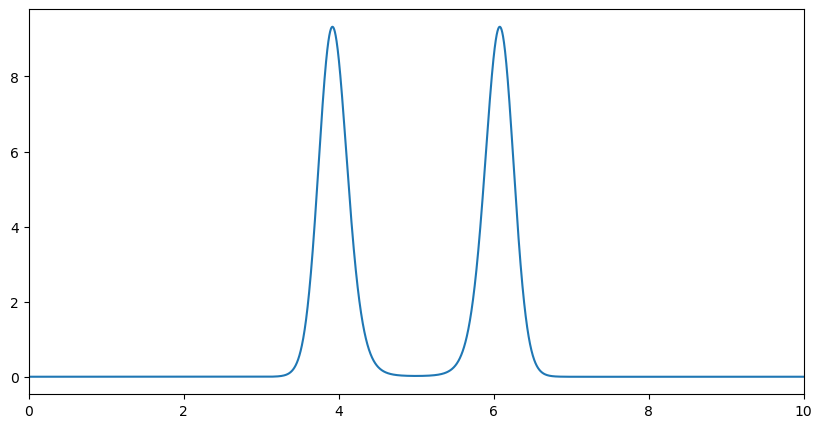

In [4]:
from patsy import DesignInfo, DesignMatrix, build_design_matrices, dmatrix
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp

data = {"x": position}

df = 5

design_matrix = dmatrix(f"bs(x, df={df})", data)

weights = np.ones((design_matrix.shape[0],))
weights[is_inbound] = 0.0


@jax.jit
def neglogp(coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights):
    conditional_intensity = jnp.exp(design_matrix @ coefficients)
    log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
        spikes, conditional_intensity + np.spacing(1)
    )
    return -log_likelihood.sum()


dlike = jax.grad(neglogp)
dlike2 = jax.hessian(neglogp)
res = minimize(neglogp, x0=np.ones((df + 1,)), method="Newton-CG", jac=dlike, hess=dlike2)

plt.figure(figsize=(10, 5))
plt.plot(time, np.exp(design_matrix @ res.x) * sampling_frequency)
plt.xlim((0, 10))


array([-4.93864165e+02,  4.67662256e+05,  3.46534770e+05,  5.28094214e+05,
        4.79926408e+05,  4.71048466e+05])

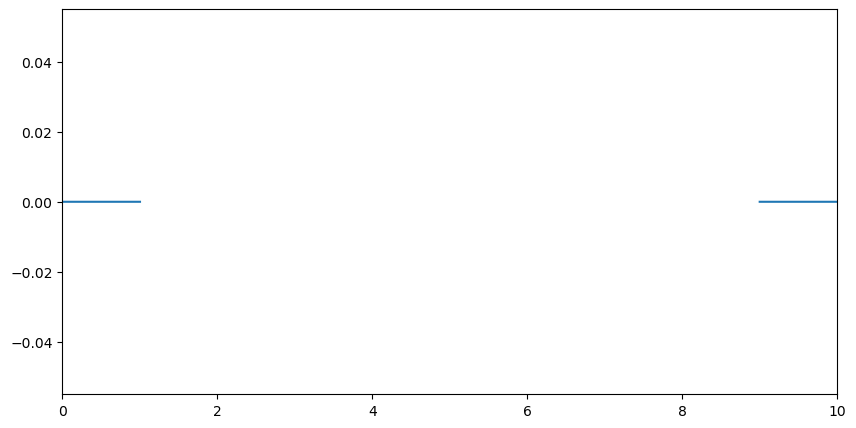

In [87]:
track_height = 170
sampling_frequency = 500
n_samples = sampling_frequency * 500

time = simulate_time(n_samples, sampling_frequency)
position = simulate_position(time, track_height)[:, np.newaxis]

trajectory_direction, is_inbound = get_trajectory_direction(position.squeeze())

spikes = simulate_neuron_with_place_field(
    [50],
    position,
    max_rate=30,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Inbound"),
) + simulate_neuron_with_place_field(
    [150],
    position,
    max_rate=10,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Outbound"),
)

spikes = np.random.poisson(50 * np.ones((position.shape[0],)) / sampling_frequency)

df=5
penalty=1e-2
data = {"x": position}
design_matrix = dmatrix(f"cr(x, df={df}, constraints='center')", data)
weights = np.ones((design_matrix.shape[0],))

@jax.jit
def neglogp(
    coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
):
    conditional_intensity = jnp.exp(design_matrix @ coefficients)
    log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
        spikes.astype(float), conditional_intensity + np.spacing(1)
    ) / spikes.shape[0] - penalty * jnp.sum(coefficients[1:]**2) / 2
    
    return -log_likelihood.sum()

dlike = jax.grad(neglogp)
dlike2 = jax.hessian(neglogp)
initial_conditions = np.ones((design_matrix.shape[1],))

res = minimize(
    neglogp, x0=initial_conditions, method="Newton-CG", jac=dlike, hess=dlike2
)
conditional_intensity = jnp.exp(design_matrix @ res.x)

plt.figure(figsize=(10, 5))
plt.plot(time, conditional_intensity * sampling_frequency)
plt.xlim((0, 10))
res.x

1144178953450.962

In [54]:
design_matrix

DesignMatrix with shape (250000, 6)
  Columns:
    ['Intercept',
     "cr(x, df=5, constraints='center')[0]",
     "cr(x, df=5, constraints='center')[1]",
     "cr(x, df=5, constraints='center')[2]",
     "cr(x, df=5, constraints='center')[3]",
     "cr(x, df=5, constraints='center')[4]"]
  Terms:
    'Intercept' (column 0)
    "cr(x, df=5, constraints='center')" (columns 1:6)
  (to view full data, use np.asarray(this_obj))

In [34]:
def fit_regression(weights):
    data = {"x": position}

    df = 5

    design_matrix = dmatrix(f"bs(x, df={df})", data)

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)

    res = minimize(
        neglogp, x0=np.ones((design_matrix.shape[1])), method="Newton-CG", jac=dlike, hess=dlike2
    )
    conditional_intensity = jnp.exp(design_matrix @ res.x)

    return conditional_intensity


def fit_regression2(weights):

    df = 5

    design_matrix = np.ones((weights.shape[0], 1))

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)

    res = minimize(
        neglogp, x0=spikes.mean(), method="Newton-CG", jac=dlike, hess=dlike2
    )
    conditional_intensity = jnp.exp(design_matrix @ res.x)

    return conditional_intensity


def fit_regression_regularized(weights, spikes, position, df=5, penalty=1e-6):
    data = {"x": position}
    design_matrix = dmatrix(f"cr(x, df={df}, constraints='center')", data)

    @jax.jit
    def neglogp(
        coefficients_penalty, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        penalty = coefficients_penalty[0]
        coefficients = coefficients_penalty[1:]
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity + np.spacing(1)
        ) + penalty * jnp.linalg.norm(coefficients[1:])
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)
    initial_conditions = np.concatenate([[penalty], [np.log(spikes.mean())], np.zeros((design_matrix.shape[1] - 1))])

    res = minimize(
        neglogp, x0=initial_conditions, method="Newton-CG", jac=dlike, hess=dlike2
    )
    conditional_intensity = jnp.exp(design_matrix @ res.x[1:])

    return conditional_intensity

-3.3808066920144215

In [41]:
from src.hmm import (
    forward,
    correction_smoothing,
    update_transition_matrix_from_correction_smoothing,
    viterbi,
    check_converged,
)

import matplotlib.pyplot as plt

track_height = 170
sampling_frequency = 500
n_samples = sampling_frequency * 500

time = simulate_time(n_samples, sampling_frequency)
position = simulate_position(time, track_height)[:, np.newaxis]

trajectory_direction, is_inbound = get_trajectory_direction(position.squeeze())

spikes = simulate_neuron_with_place_field(
    [50],
    position,
    max_rate=30,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Inbound"),
) + simulate_neuron_with_place_field(
    [150],
    position,
    max_rate=10,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Outbound"),
)

spikes = simulate_neuron_with_place_field(
    [50],
    position,
    max_rate=30,
    variance=36,
    sampling_frequency=sampling_frequency,
    is_condition=(trajectory_direction == "Inbound"),
)

spikes[spikes.shape[0]//3:2 * spikes.shape[0]//3] = np.random.poisson(50 * np.ones((spikes[spikes.shape[0]//3:2 * spikes.shape[0]//3].shape)) / sampling_frequency)


tolerance = 1e-4
max_iter = 50

data_log_likelihoods = []
n_iter = 0
converged = False

n_states = 2
n_time = spikes.shape[0]
initial_conditions = np.ones((n_states,)) / n_states
transition_matrix = np.asarray([[0.9, 0.1],
                                [0.1, 0.9]])
is_training = np.ones((n_time,))
is_training[: n_time // 2] = 0.0
# is_training = (trajectory_direction == "Inbound")

while not converged and (n_iter < max_iter):
    predict_rates = np.stack(
        (
            fit_regression(is_training.astype(float)),
            fit_regression(1 - is_training.astype(float)),
        ),
        axis=1
    )
    likelihood = np.exp(poisson_log_likelihood(spikes[:, np.newaxis], predict_rates))

    # Expectation step
    causal_posterior, data_log_likelihood, scaling = forward(
        initial_conditions, likelihood, transition_matrix
    )

    acausal_posterior = correction_smoothing(causal_posterior, transition_matrix)

    # Maximization step
    transition_matrix = update_transition_matrix_from_correction_smoothing(
        causal_posterior,
        acausal_posterior,
        likelihood,
        transition_matrix,
    )

    is_training = acausal_posterior[:, 0]
    initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(data_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}"
        )

predicted_state = viterbi(initial_conditions, likelihood, transition_matrix)[0]


iteration 1, likelihood: -37488.45959638033
iteration 2, likelihood: -37487.19715009142, change: 1.2624462889070855


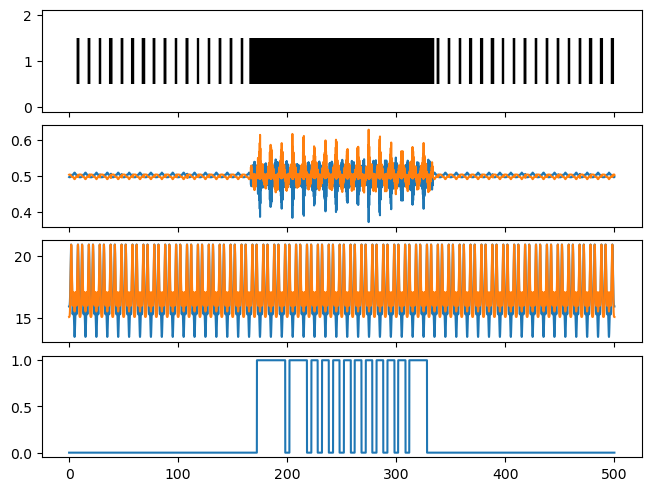

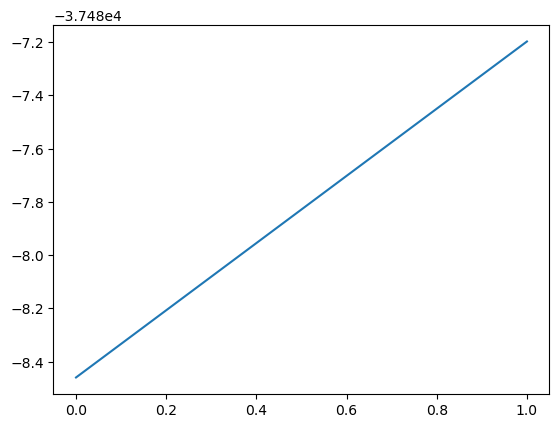

In [42]:
fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True)

spike_time_ind = np.nonzero(spikes)[0]
# axes[0].plot(time, true_rate)
axes[0].eventplot(time[spike_time_ind], color="black")

axes[1].plot(time, acausal_posterior)
axes[2].plot(time, predict_rates * sampling_frequency)
# axes[2].plot(time, true_rate, linestyle="--")
axes[3].plot(time, predicted_state)

plt.figure()
plt.plot(data_log_likelihoods)

In [9]:
acausal_posterior

array([[0.12917217, 0.87082783],
       [0.14300802, 0.85699198],
       [0.1564903 , 0.8435097 ],
       ...,
       [0.68201408, 0.31798592],
       [0.68231587, 0.31768413],
       [0.68262562, 0.31737438]])